## Import Libraries 

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import sklearn
import time

import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer 
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


import warnings
warnings.filterwarnings('ignore')

## Load Data

In [5]:
stroke_df = pd.read_csv("stroke_data.csv")
stroke_df = stroke_df.drop('id', axis = 1)

In [6]:
stroke_df.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [7]:
stroke_df.shape

(5110, 11)

In [8]:
stroke_df.isna().any()

gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

In [9]:
#Frequency Count for target variable 
stroke_df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [10]:
stroke_df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Observations: 1) This dataset is unblanced which will end up skewing our model's results. We will deal with this later on; 2) We have some missing values in the 'bmi' feature. We will have to deal with this as well. 

## Exploratory Data Analysis (EDA)

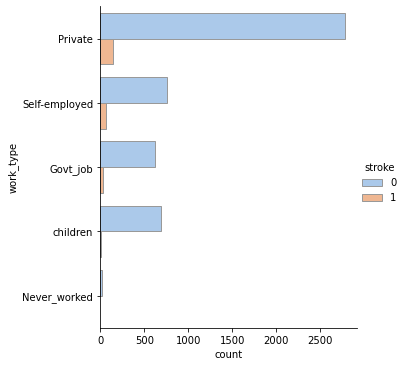

In [11]:
sns.catplot(y = 'work_type', hue = 'stroke', kind = 'count', palette = 'pastel', edgecolor = '.6', data = stroke_df )

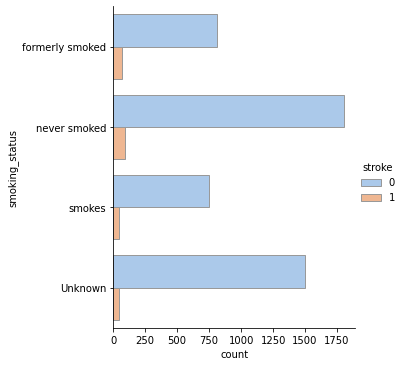

In [12]:
sns.catplot(y="smoking_status", hue="stroke", kind="count",
            palette="pastel", edgecolor=".6",
            data=stroke_df)

<Figure size 1224x504 with 0 Axes>

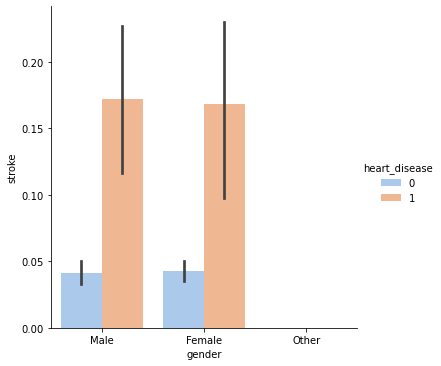

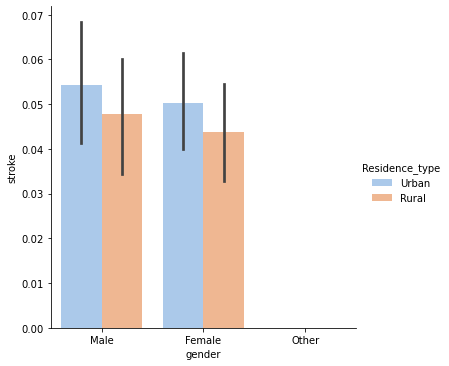

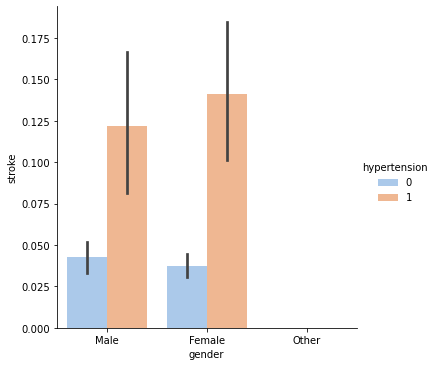

In [13]:
plt.figure(figsize = (17,7)) 
sns.catplot(x="gender", y="stroke", hue="heart_disease", palette="pastel", kind="bar", data=stroke_df)
sns.catplot(x="gender", y="stroke", hue="Residence_type", palette="pastel", kind="bar", data=stroke_df)
sns.catplot(x="gender", y="stroke", hue="hypertension", palette="pastel", kind="bar", data=stroke_df)
plt.show()

<AxesSubplot:>

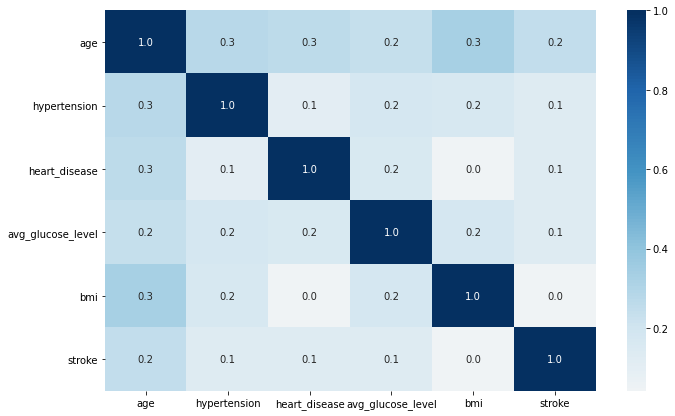

In [14]:
corr = stroke_df.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,7)
sns.heatmap(corr, annot = True, fmt = ".1f", cmap = 'RdBu', center = 0, ax = ax)


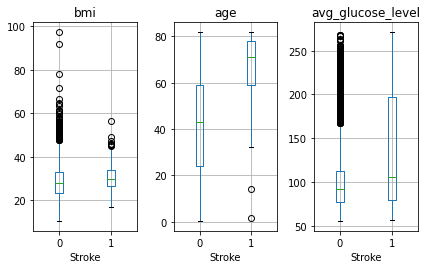

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3)
stroke_df.boxplot(column = 'bmi', by = 'stroke', ax = axes[0])
stroke_df.boxplot(column = 'age', by = 'stroke', ax = axes[1])
stroke_df.boxplot(column = 'avg_glucose_level', by = 'stroke', ax = axes[2])


for ax in axes:
    ax.set_xlabel('Stroke')
    
plt.suptitle('')
plt.tight_layout()

Observations:

1) Gender is not a feature that determines whether a person has a stroke or not

2) There's a high correlation between the hypertension variable and stroke

3) Suprisngly, it seems like smokers aren't at a high risk to have a stroke 

## Data Cleaning & Preperation 

In [16]:
le = LabelEncoder()
en_df = stroke_df.apply(le.fit_transform)

In [17]:
en_df_imp = en_df
imputer = KNNImputer(n_neighbors=4, weights="uniform")
imputer.fit_transform(en_df_imp)

array([[  1.,  88.,   0., ..., 239.,   1.,   1.],
       [  0.,  82.,   0., ..., 418.,   2.,   1.],
       [  1., 101.,   0., ..., 198.,   2.,   1.],
       ...,
       [  0.,  56.,   0., ..., 179.,   2.,   0.],
       [  1.,  72.,   0., ..., 129.,   1.,   0.],
       [  0.,  65.,   0., ..., 135.,   0.,   0.]])

In [18]:
from imblearn.over_sampling import SMOTE

In [19]:
X = en_df_imp.drop(['stroke'], axis = 1)
y = en_df_imp['stroke']

In [20]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

## Split Data

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Model Building

In [24]:
parameters = {
        'max_depth': range(2, 6),
        'n_estimators': [50, 100, 150, 200, 250, 300],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 1],
        'colsample_bynode': [0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 1],
        'gamma': [0, 5, 10, 15, 20],
        'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
        'lambda': [0.1, 0.25, 0.5, 0.75, 1]
}

start = time.time() 

clf = RandomizedSearchCV(xgb.XGBClassifier(use_label_encoder = False, eval_metric = "logloss"), 
                         parameters, n_jobs=4, scoring = "roc_auc", n_iter = 300,
                         random_state = 123)

clf.fit(X_train, y_train)

end = time.time()

# print the number of seconds it takes to run the hyperparameter search
print("Total time in seconds ==> ", end - start)


Total time in seconds ==>  855.0761020183563


In [25]:
train_pred = clf.predict(X_train)
val_pred = clf.predict(X_valid)

## Feature Importance 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance score', ylabel='Features'>

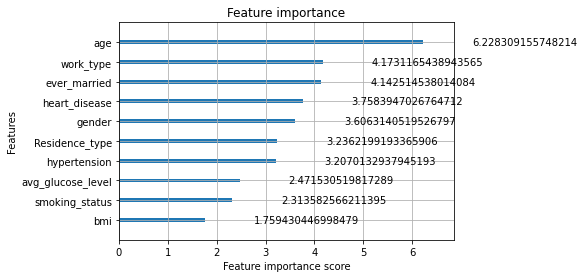

In [31]:
# non-normalized feature importance
# XGBoost has a built-in function to plot importance
xgb.plot_importance(clf.best_estimator_, importance_type = "gain", xlabel = "Feature importance score")

## Model Results

In [26]:
print("Training recall: ", metrics.recall_score(y_train, train_pred))
print("Validation recall: ", metrics.recall_score(y_valid, val_pred))

print("\n")

print("Training precision: ", metrics.precision_score(y_train, train_pred))
print("Validation precision: ", metrics.precision_score(y_valid, val_pred))

print("\n")

print("Training accuracy: ", metrics.accuracy_score(y_train, train_pred))
print("Validation accuracy: ", metrics.accuracy_score(y_valid, val_pred))

print("\n")

y_train_prob = clf.predict_proba(X_train)
y_val_prob = clf.predict_proba(X_valid)

fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_prob[:,1], pos_label = 1)
print("Training AUC: ", metrics.auc(fpr, tpr))

fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_val_prob[:,1], pos_label = 1)
print("Validation AUC: ", metrics.auc(fpr, tpr))

Training recall:  0.9979417818288738
Validation recall:  0.9582191780821918


Training precision:  0.9869148008141901
Validation precision:  0.9119947848761408


Training accuracy:  0.9923585598824394
Validation accuracy:  0.932807679122386


Training AUC:  0.999797875167012
Validation AUC:  0.979887129680992


In [28]:
thresh = np.arange(0.01, 1, .01) # create array 0.01, 0.02, 0.03, ..., 0.99

# create empty lists for each metric
precision_values = []
recall_values = []
acc_values = []
f1_values = []

# Loop through each threshold value - .01, .02, .03, ..., .99
for val in thresh:
    
    # get 1 / 0 predictions based off probability threshold
    pred = [1 if prob >= val else 0 for prob in y_train_prob[:,1]]
    
    # calculate precision, recall, accuracy, and f1-score
    precision = metrics.precision_score(y_train, pred)
    recall = metrics.recall_score(y_train, pred)
    accuracy = metrics.accuracy_score(y_train, pred)
    f1_score = metrics.f1_score(y_train, pred)
    
    # add precision, recall, accuracy, and f1-score to their respective lists
    precision_values.append(precision)
    recall_values.append(recall)
    acc_values.append(accuracy)
    f1_values.append(f1_score)

# put precision, recall, and accuracy values into a data frame
result = pd.DataFrame()
result["threshold"] = thresh
result["precision"] = precision_values
result["recall"] = recall_values
result["accuracy"] = acc_values
result["f1_score"] = f1_values

result 

,threshold,precision,recall,accuracy,f1_score
0,0.01,0.741605,1.000000,0.825863,0.851634
1,0.02,0.774715,1.000000,0.854666,0.873059
2,0.03,0.796114,1.000000,0.872006,0.886485
3,0.04,0.814221,1.000000,0.885966,0.897598
4,0.05,0.829917,1.000000,0.897575,0.907054
...,...,...,...,...,...
94,0.95,1.000000,0.739782,0.869949,0.850431
95,0.96,1.000000,0.691561,0.845849,0.817660
96,0.97,1.000000,0.625698,0.812932,0.769759
97,0.98,1.000000,0.527786,0.763997,0.690916


In [29]:
result.iloc[result.f1_score.idxmax()]

threshold    0.590000
precision    0.993539
recall       0.994707
accuracy     0.994122
f1_score     0.994123
Name: 58, dtype: float64

In [30]:
## Use above threshold to calculate accuracy, precision, recall, and F1-score on validation set

# get 1 / 0 predictions based off probability threshold
pred = [1 if prob >= 0.4 else 0 for prob in y_val_prob[:,1]]

# calculate precision, recall, accuracy, and f1-score
precision = metrics.precision_score(y_valid, pred)
recall = metrics.recall_score(y_valid, pred)
accuracy = metrics.accuracy_score(y_valid, pred)
f1_score = metrics.f1_score(y_valid, pred)

print("Validation precision: ", precision)
print("Validation recall: ", recall)
print("Validation accuracy: ", accuracy)
print("Validation F1-Score: ", f1_score)

Validation precision:  0.8958730158730158
Validation recall:  0.9664383561643836
Validation accuracy:  0.926979773740144
Validation F1-Score:  0.9298187808896211
